# 14 — Evaluasi Komprehensif & Error Analysis

Notebook ini melengkapi tahap **Evaluasi Kinerja Model (3.1.6)** dengan:

1. **Confusion Matrix** — token-level (13-class BIEOS & simplified 4-class)
2. **Error Analysis** — entity-level breakdown (boundary, sentiment, missed, hallucinated)
3. **Error Propagation Analysis** — 3-level comparison: Softmax → CRF → MTL+CRF
4. **Tabel Perbandingan Formal** — semua model vs EMC-GCN baseline
5. **Contoh Prediksi Kualitatif** — input → ground truth → prediksi per model (3 level)

**Data source**:
- `checkpoint_extended_training.pt` dari NB10 (MT & ST results)
- `checkpoint_three_level.pt` dari NB11 (Softmax baseline + 3-level comparison)

In [46]:
import json
import os
from collections import Counter, defaultdict

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10

print('Libraries loaded.')

Libraries loaded.


In [47]:
# Paths
BASE_DIR = os.path.dirname(os.getcwd())
DATA_PROC_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models')

# Label definitions
bieos_labels = ['O', 'B-NEG', 'B-NEU', 'B-POS', 'E-NEG', 'E-NEU', 'E-POS',
                'I-NEG', 'I-NEU', 'I-POS', 'S-NEG', 'S-NEU', 'S-POS']
bieos_label2id = {l: i for i, l in enumerate(bieos_labels)}
bieos_id2label = {i: l for l, i in bieos_label2id.items()}

# Reference
PRIOR_RESEARCH_F1 = 0.6761
SEED = 42
TRAIN_RATIO = 0.85

In [48]:
# Load checkpoint dari NB10 (4 runs: MT/ST × Orig/Aug)
ckpt_path = os.path.join(MODEL_DIR, 'checkpoint_extended_training.pt')
checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=False)
all_results = checkpoint['results']

# Load checkpoint dari NB11 (3-level: Softmax/CRF/MTL × Orig/Aug)
ckpt_3level_path = os.path.join(MODEL_DIR, 'checkpoint_three_level.pt')
ckpt_3level = torch.load(ckpt_3level_path, map_location='cpu', weights_only=False)
three_level_results = ckpt_3level['all_results']

print('NB10 Runs:')
for name, r in all_results.items():
    print(f'  {name}: F1={r["best_f1"]:.4f}, {len(r["val_true"])} val samples')

print(f'\nNB11 Runs (3-level):')
for name, r in three_level_results.items():
    level = r.get('level', '?')
    print(f'  L{level} {name}: F1={r["best_f1"]:.4f}, {len(r["val_true"])} val samples')

NB10 Runs:
  MT + Original: F1=0.7578, 368 val samples
  MT + Augmented: F1=0.7442, 368 val samples
  ST + Original: F1=0.7558, 368 val samples
  ST + Augmented: F1=0.7600, 368 val samples

NB11 Runs (3-level):
  L1 Baseline + Original: F1=0.7466, 368 val samples
  L1 Baseline + Augmented: F1=0.7593, 368 val samples
  L2 ST + Original: F1=0.7558, 368 val samples
  L2 ST + Augmented: F1=0.7600, 368 val samples
  L3 MT + Original: F1=0.7578, 368 val samples
  L3 MT + Augmented: F1=0.7442, 368 val samples


In [49]:
# Load val text tokens untuk qualitative analysis
# Augmented val file = original val split (368 samples)
with open(os.path.join(DATA_PROC_DIR, 'train_data_bieos_val.json'), 'r', encoding='utf-8') as f:
    val_data_aug = json.load(f)

# Reconstruct original val split (same 368 samples, tapi urutan dari random permutation)
with open(os.path.join(DATA_PROC_DIR, 'train_data_bieos.json'), 'r', encoding='utf-8') as f:
    all_data = json.load(f)

orig_indices = torch.randperm(len(all_data), generator=torch.Generator().manual_seed(SEED))
split_point = int(len(all_data) * TRAIN_RATIO)
val_indices_orig = orig_indices[split_point:].tolist()
val_data_orig = [all_data[i] for i in val_indices_orig]

print(f'Val (augmented file): {len(val_data_aug)} samples')
print(f'Val (original split): {len(val_data_orig)} samples')

# Verify: cek apakah kedua val set berisi sampel yang sama
aug_tokens_set = set(tuple(d['tokens']) for d in val_data_aug)
orig_tokens_set = set(tuple(d['tokens']) for d in val_data_orig)
overlap = len(aug_tokens_set & orig_tokens_set)
print(f'Overlap: {overlap}/{len(val_data_aug)} ({overlap/len(val_data_aug)*100:.1f}%)')

Val (augmented file): 368 samples
Val (original split): 368 samples
Overlap: 368/368 (100.0%)


---
## 1. Confusion Matrix (Token-Level)

In [50]:
def flatten_labels(label_sequences):
    """Flatten list of label sequences into single list."""
    return [label for seq in label_sequences for label in seq]


def simplify_label(label):
    """Collapse BIEOS-sentiment label to sentiment only: O/POS/NEG/NEU."""
    if label == 'O':
        return 'O'
    parts = label.split('-', 1)
    if len(parts) == 2:
        return parts[1]  # POS, NEG, or NEU
    return label


def plot_confusion_matrix(y_true, y_pred, labels, title, ax, normalize=True, fmt='.1%'):
    """Plot confusion matrix heatmap."""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if normalize:
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        cm_display = cm / row_sums
    else:
        cm_display = cm
        fmt = 'd'
    
    sns.heatmap(cm_display, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=ax,
                vmin=0, vmax=1 if normalize else None,
                linewidths=0.5, linecolor='white')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title, fontweight='bold')


print('Helper functions defined.')

Helper functions defined.


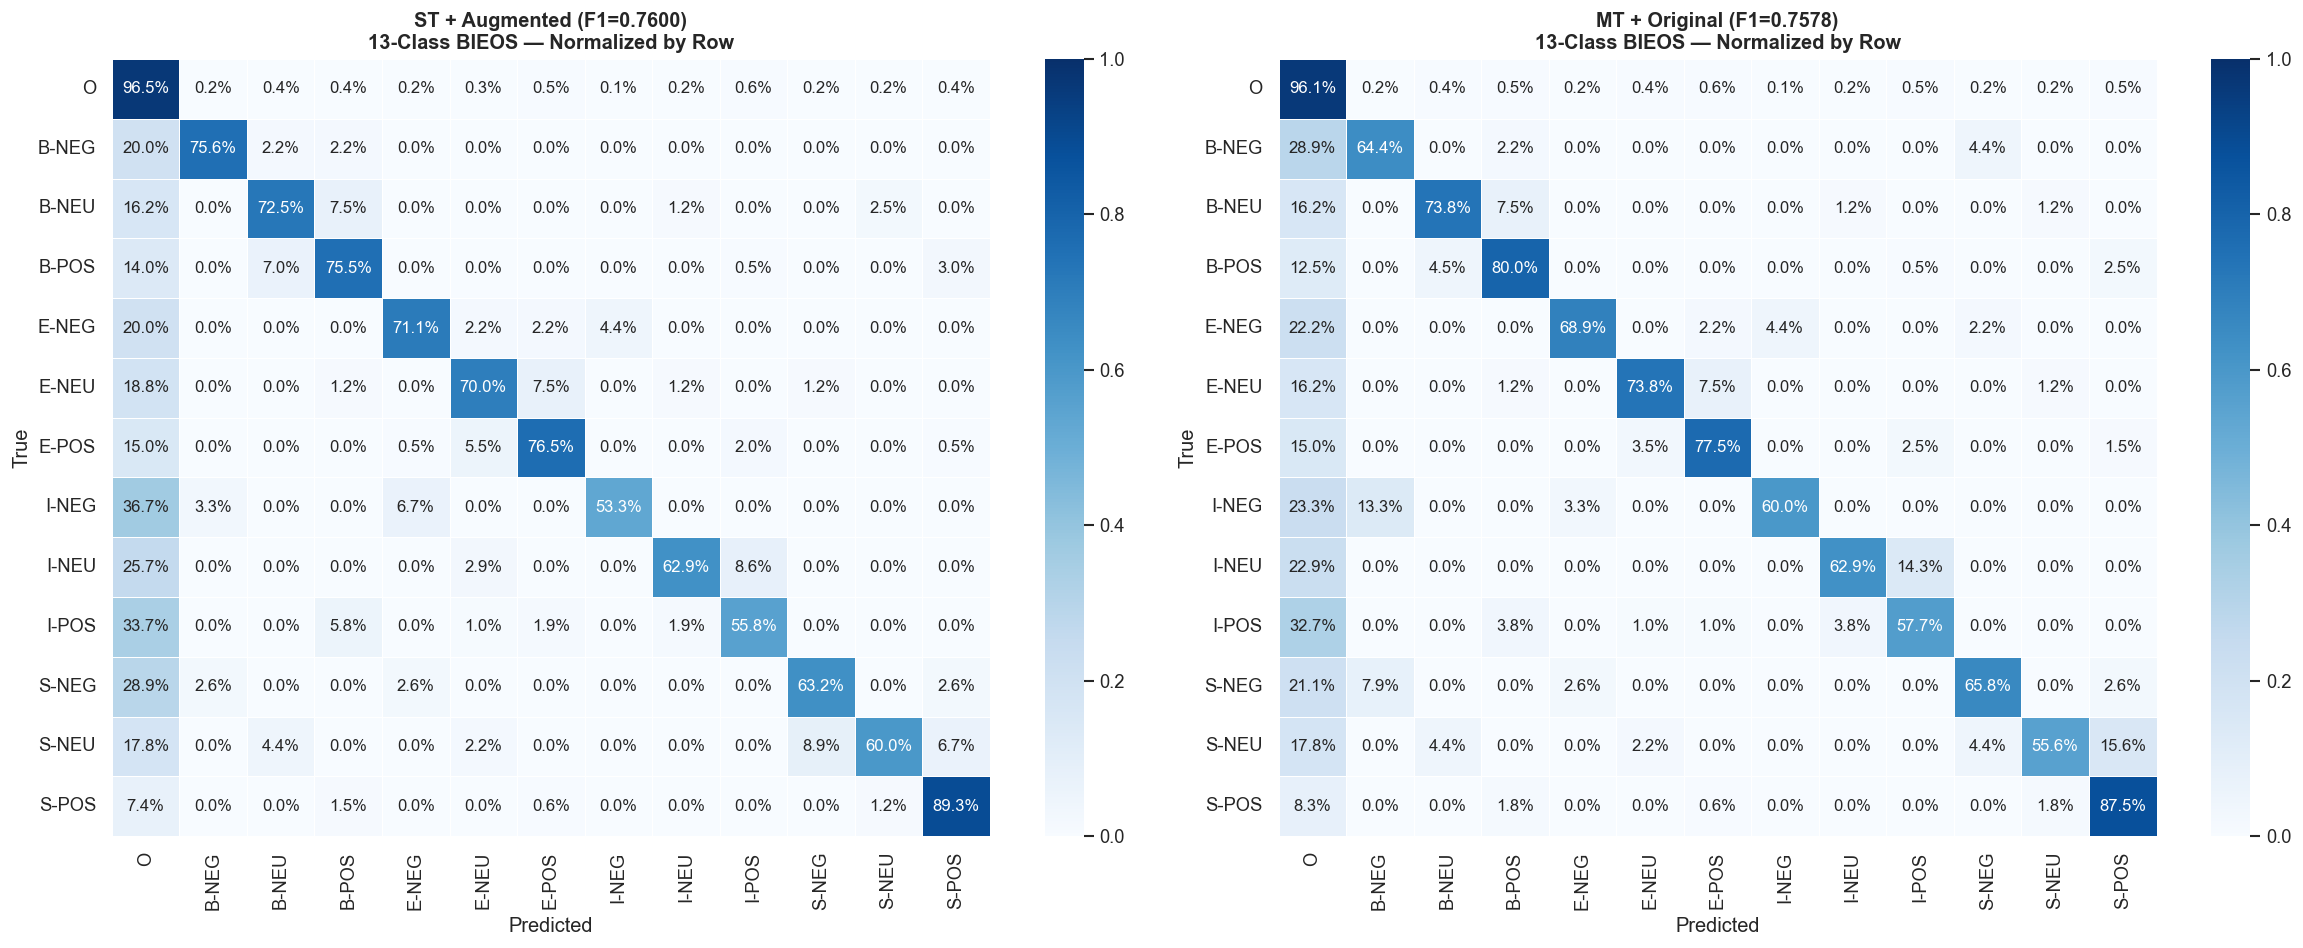

In [51]:
# --- 13-Class BIEOS Confusion Matrix ---
# Fokus pada 2 model terbaik: ST+Augmented dan MT+Original
focus_runs = ['ST + Augmented', 'MT + Original']

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for idx, run_name in enumerate(focus_runs):
    r = all_results[run_name]
    y_true = flatten_labels(r['val_true'])
    y_pred = flatten_labels(r['val_preds'])
    
    # Filter out labels not present in data
    present = sorted(set(y_true) | set(y_pred), key=lambda x: bieos_label2id.get(x, 99))
    
    plot_confusion_matrix(
        y_true, y_pred, present,
        f'{run_name} (F1={r["best_f1"]:.4f})\n13-Class BIEOS — Normalized by Row',
        axes[idx]
    )

plt.tight_layout()
plt.show()

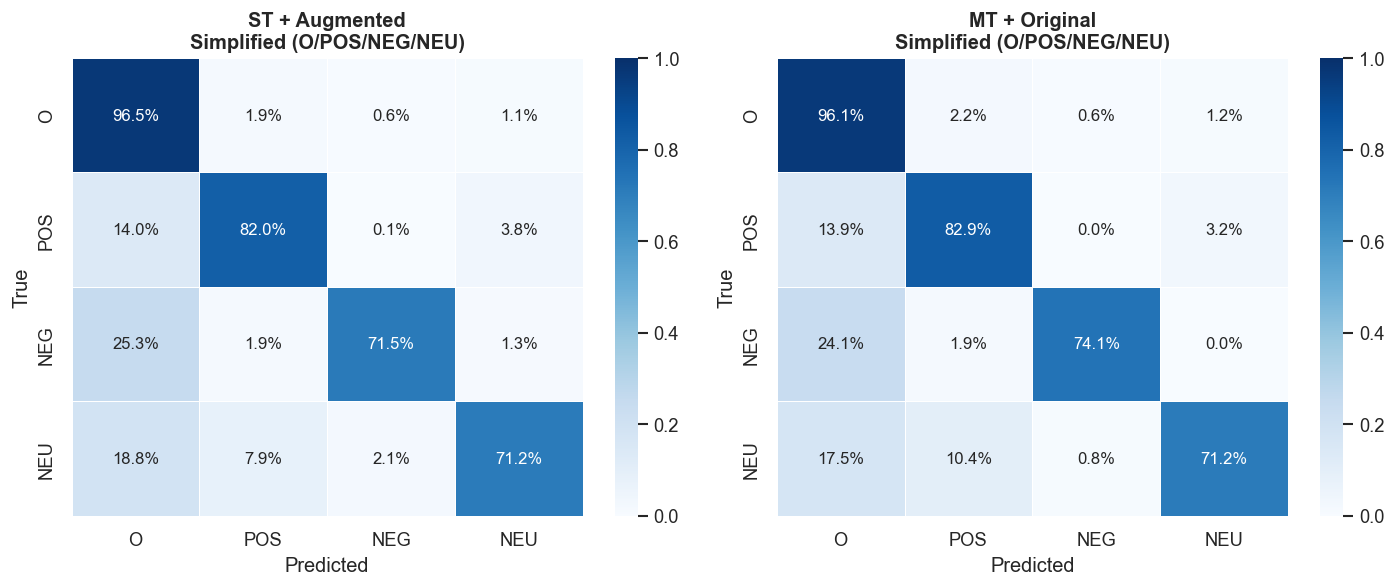


ST + Augmented — Token counts:
  True distribution:  [('O', 6521), ('POS', 840), ('NEU', 240), ('NEG', 158)]
  Pred distribution:  [('O', 6495), ('POS', 832), ('NEU', 275), ('NEG', 157)]

MT + Original — Token counts:
  True distribution:  [('O', 6521), ('POS', 840), ('NEU', 240), ('NEG', 158)]
  Pred distribution:  [('O', 6465), ('POS', 865), ('NEU', 274), ('NEG', 155)]


In [52]:
# --- Simplified 4-Class Confusion Matrix (O / POS / NEG / NEU) ---
simplified_labels = ['O', 'POS', 'NEG', 'NEU']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, run_name in enumerate(focus_runs):
    r = all_results[run_name]
    y_true = [simplify_label(l) for l in flatten_labels(r['val_true'])]
    y_pred = [simplify_label(l) for l in flatten_labels(r['val_preds'])]
    
    plot_confusion_matrix(
        y_true, y_pred, simplified_labels,
        f'{run_name}\nSimplified (O/POS/NEG/NEU)',
        axes[idx]
    )

plt.tight_layout()
plt.show()

# Print raw counts for reference
for run_name in focus_runs:
    r = all_results[run_name]
    y_true = [simplify_label(l) for l in flatten_labels(r['val_true'])]
    y_pred = [simplify_label(l) for l in flatten_labels(r['val_preds'])]
    print(f'\n{run_name} — Token counts:')
    print(f'  True distribution:  {Counter(y_true).most_common()}')
    print(f'  Pred distribution:  {Counter(y_pred).most_common()}')

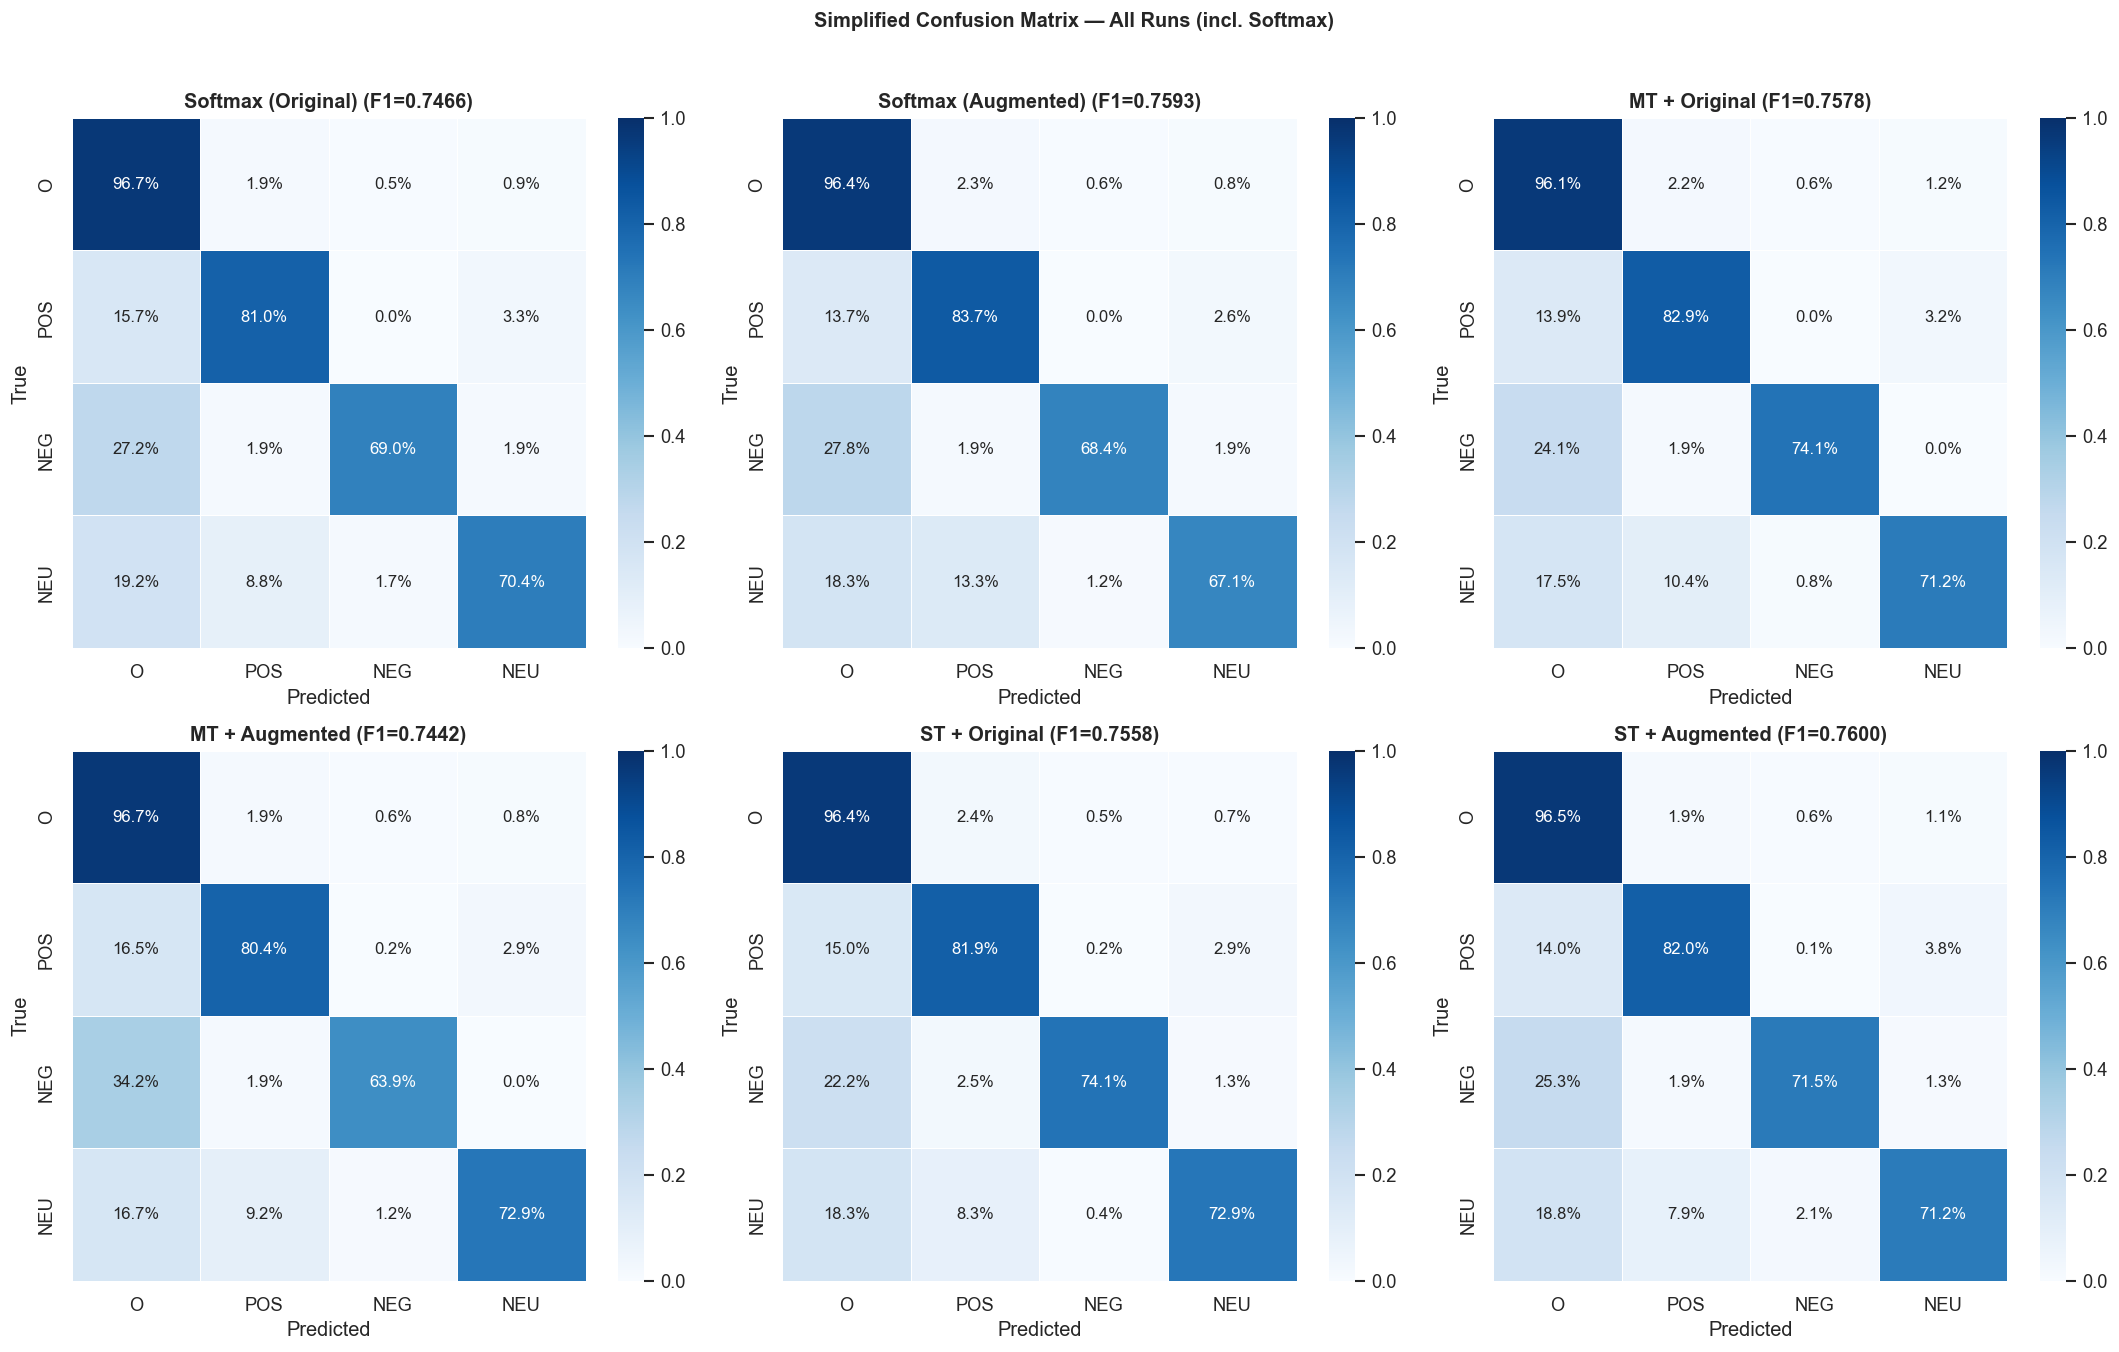

In [53]:
# --- Semua 4 run NB10 + Softmax dari NB11: Simplified Confusion Matrix ---
# Gabungkan Softmax baseline ke dalam analisis
softmax_runs = {k: v for k, v in three_level_results.items() if v.get('level') == 1}

all_runs_combined = {}
for name, r in softmax_runs.items():
    all_runs_combined[f'Softmax ({r["data_type"].title()})'] = r
for name, r in all_results.items():
    all_runs_combined[name] = r

n_runs = len(all_runs_combined)
ncols = 3
nrows = (n_runs + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5.5 * nrows))
axes = axes.flatten()

for idx, (run_name, r) in enumerate(all_runs_combined.items()):
    y_true = [simplify_label(l) for l in flatten_labels(r['val_true'])]
    y_pred = [simplify_label(l) for l in flatten_labels(r['val_preds'])]
    
    plot_confusion_matrix(
        y_true, y_pred, simplified_labels,
        f'{run_name} (F1={r["best_f1"]:.4f})',
        axes[idx]
    )

for idx in range(n_runs, nrows * ncols):
    axes[idx].set_visible(False)

plt.suptitle('Simplified Confusion Matrix — All Runs (incl. Softmax)', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 2. Entity-Level Error Analysis

Mengekstrak entitas (aspect spans) dari sequence BIEOS, lalu mengklasifikasikan error:
- **Exact Match**: boundary & sentiment benar
- **Boundary Error**: partial overlap tapi sentiment benar
- **Sentiment Error**: boundary exact match tapi sentiment salah
- **Both Error**: boundary & sentiment salah
- **Missed**: entitas di ground truth tapi tidak terdeteksi
- **Hallucinated**: entitas diprediksi tapi tidak ada di ground truth

In [54]:
def extract_entities(label_seq):
    """Extract entities from BIEOS label sequence.
    Returns list of (sentiment, start, end) tuples.
    """
    entities = []
    i = 0
    while i < len(label_seq):
        label = label_seq[i]
        if label.startswith('S-'):
            sentiment = label.split('-', 1)[1]
            entities.append((sentiment, i, i))
        elif label.startswith('B-'):
            sentiment = label.split('-', 1)[1]
            start = i
            end = i
            i += 1
            while i < len(label_seq):
                if label_seq[i].startswith('I-'):
                    end = i
                elif label_seq[i].startswith('E-'):
                    end = i
                    break
                else:
                    end = i - 1
                    i -= 1
                    break
                i += 1
            entities.append((sentiment, start, end))
        i += 1
    return entities


def classify_errors(true_entities, pred_entities):
    """Classify prediction errors at entity level.
    Returns dict with error categories and details.
    """
    true_set = set((s, st, en) for s, st, en in true_entities)
    pred_set = set((s, st, en) for s, st, en in pred_entities)
    
    exact_match = true_set & pred_set
    
    true_remaining = true_set - exact_match
    pred_remaining = pred_set - exact_match
    
    sentiment_errors = []   # exact boundary, wrong sentiment
    boundary_errors = []    # overlapping span, correct sentiment
    both_errors = []        # overlapping span, wrong sentiment
    missed = []             # no overlap at all
    hallucinated = []       # no overlap at all
    
    pred_matched = set()
    
    for t_sent, t_start, t_end in true_remaining:
        best_match = None
        best_overlap = 0
        
        for p_sent, p_start, p_end in pred_remaining:
            if (p_sent, p_start, p_end) in pred_matched:
                continue
            # Check overlap
            overlap_start = max(t_start, p_start)
            overlap_end = min(t_end, p_end)
            if overlap_start <= overlap_end:
                overlap = overlap_end - overlap_start + 1
                if overlap > best_overlap:
                    best_overlap = overlap
                    best_match = (p_sent, p_start, p_end)
        
        if best_match is not None:
            p_sent, p_start, p_end = best_match
            pred_matched.add(best_match)
            
            exact_boundary = (t_start == p_start and t_end == p_end)
            same_sentiment = (t_sent == p_sent)
            
            if exact_boundary and not same_sentiment:
                sentiment_errors.append({
                    'true': (t_sent, t_start, t_end),
                    'pred': (p_sent, p_start, p_end)
                })
            elif not exact_boundary and same_sentiment:
                boundary_errors.append({
                    'true': (t_sent, t_start, t_end),
                    'pred': (p_sent, p_start, p_end)
                })
            elif not exact_boundary and not same_sentiment:
                both_errors.append({
                    'true': (t_sent, t_start, t_end),
                    'pred': (p_sent, p_start, p_end)
                })
        else:
            missed.append((t_sent, t_start, t_end))
    
    for p_sent, p_start, p_end in pred_remaining:
        if (p_sent, p_start, p_end) not in pred_matched:
            hallucinated.append((p_sent, p_start, p_end))
    
    return {
        'exact_match': list(exact_match),
        'sentiment_error': sentiment_errors,
        'boundary_error': boundary_errors,
        'both_error': both_errors,
        'missed': missed,
        'hallucinated': hallucinated,
    }




def entities_to_readable(entities, tokens):
    """Convert entity list to readable format: 'aspect_text (SENTIMENT)'"""
    parts = []
    for sent, start, end in entities:
        if start <= end < len(tokens):
            text = ' '.join(tokens[start:end+1])
            parts.append(f'{text} ({sent})')
    return parts if parts else ['(none)']


print('Entity extraction, error classification & display helpers defined.')

Entity extraction, error classification & display helpers defined.


In [55]:
# Run error analysis untuk semua 4 konfigurasi
error_summaries = {}

for run_name, r in all_results.items():
    total_errors = defaultdict(int)
    sentiment_confusions = []  # for sentiment error analysis
    total_true_entities = 0
    total_pred_entities = 0
    
    for true_seq, pred_seq in zip(r['val_true'], r['val_preds']):
        true_ents = extract_entities(true_seq)
        pred_ents = extract_entities(pred_seq)
        total_true_entities += len(true_ents)
        total_pred_entities += len(pred_ents)
        
        errors = classify_errors(true_ents, pred_ents)
        total_errors['exact_match'] += len(errors['exact_match'])
        total_errors['sentiment_error'] += len(errors['sentiment_error'])
        total_errors['boundary_error'] += len(errors['boundary_error'])
        total_errors['both_error'] += len(errors['both_error'])
        total_errors['missed'] += len(errors['missed'])
        total_errors['hallucinated'] += len(errors['hallucinated'])
        
        # Track sentiment confusions
        for err in errors['sentiment_error']:
            sentiment_confusions.append((err['true'][0], err['pred'][0]))
        for err in errors['both_error']:
            sentiment_confusions.append((err['true'][0], err['pred'][0]))
    
    error_summaries[run_name] = {
        'counts': dict(total_errors),
        'total_true': total_true_entities,
        'total_pred': total_pred_entities,
        'sentiment_confusions': sentiment_confusions,
        'f1': r['best_f1'],
    }

# Print summary
print(f'{"Run":<20s} {"True":>6s} {"Pred":>6s} {"Exact":>6s} {"Sent":>6s} {"Bound":>6s} {"Both":>6s} {"Miss":>6s} {"Halluc":>6s}')
print('-' * 82)
for run_name, s in error_summaries.items():
    c = s['counts']
    print(f'{run_name:<20s} {s["total_true"]:>6d} {s["total_pred"]:>6d} '
          f'{c["exact_match"]:>6d} {c["sentiment_error"]:>6d} {c["boundary_error"]:>6d} '
          f'{c["both_error"]:>6d} {c["missed"]:>6d} {c["hallucinated"]:>6d}')

Run                    True   Pred  Exact   Sent  Bound   Both   Miss Halluc
----------------------------------------------------------------------------------
MT + Original           744    781    582     31     43      2     86    123
MT + Augmented          744    747    564     30     46      3    101    104
ST + Original           744    745    574     31     34      0    105    106
ST + Augmented          744    758    578     33     41      3     89    103


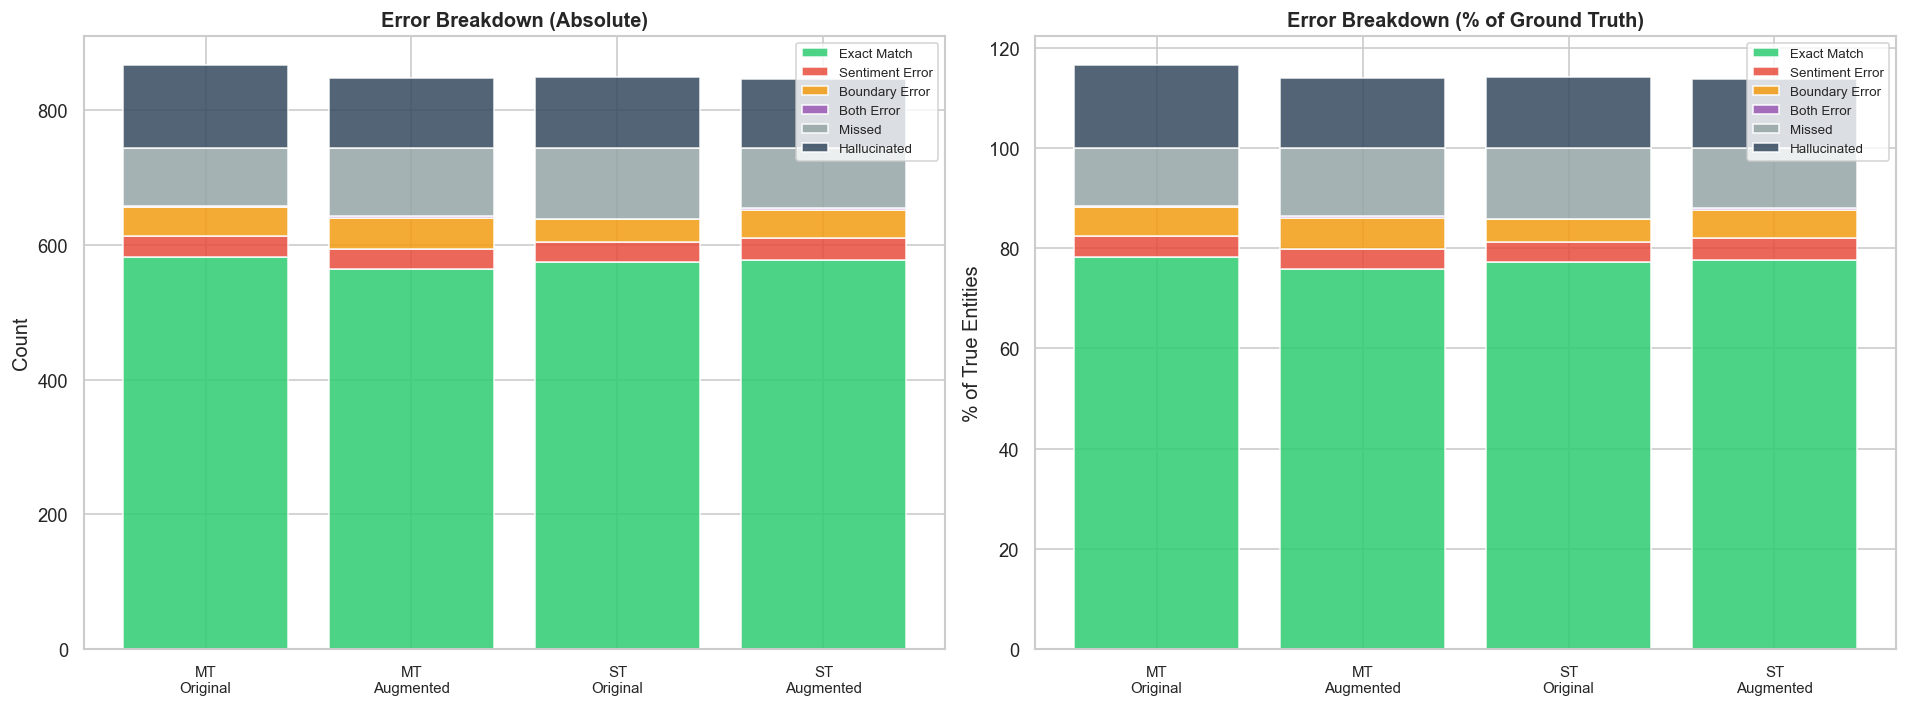

In [56]:
# Visualisasi error breakdown
categories = ['exact_match', 'sentiment_error', 'boundary_error', 'both_error', 'missed', 'hallucinated']
cat_labels = ['Exact Match', 'Sentiment\nError', 'Boundary\nError', 'Both\nError', 'Missed', 'Hallucinated']
cat_colors = ['#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#95a5a6', '#34495e']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Stacked bar chart (absolute counts)
ax = axes[0]
run_names = list(error_summaries.keys())
x = np.arange(len(run_names))
bottoms = np.zeros(len(run_names))

for cat, color, label in zip(categories, cat_colors, cat_labels):
    values = [error_summaries[n]['counts'].get(cat, 0) for n in run_names]
    ax.bar(x, values, bottom=bottoms, label=label.replace('\n', ' '), color=color, alpha=0.85)
    bottoms += values

ax.set_xticks(x)
ax.set_xticklabels([n.replace(' + ', '\n') for n in run_names], fontsize=9)
ax.set_ylabel('Count')
ax.set_title('Error Breakdown (Absolute)', fontweight='bold')
ax.legend(fontsize=8, loc='upper right')

# Right: Percentage breakdown (relative to total true entities)
ax = axes[1]
bottoms = np.zeros(len(run_names))

for cat, color, label in zip(categories, cat_colors, cat_labels):
    values = [error_summaries[n]['counts'].get(cat, 0) / error_summaries[n]['total_true'] * 100
              for n in run_names]
    ax.bar(x, values, bottom=bottoms, label=label.replace('\n', ' '), color=color, alpha=0.85)
    bottoms += values

ax.set_xticks(x)
ax.set_xticklabels([n.replace(' + ', '\n') for n in run_names], fontsize=9)
ax.set_ylabel('% of True Entities')
ax.set_title('Error Breakdown (% of Ground Truth)', fontweight='bold')
ax.legend(fontsize=8, loc='upper right')

plt.tight_layout()
plt.show()

In [57]:
# Sentiment confusion analysis
sentiments = ['POS', 'NEG', 'NEU']

print('Sentiment Confusion (entity-level, saat boundary ada overlap):')
print('='*60)

for run_name in focus_runs:
    s = error_summaries[run_name]
    confusions = s['sentiment_confusions']
    
    if not confusions:
        print(f'\n{run_name}: No sentiment confusions')
        continue
    
    print(f'\n{run_name} (F1={s["f1"]:.4f}):')
    conf_counter = Counter(confusions)
    for (true_s, pred_s), count in conf_counter.most_common():
        print(f'  {true_s} → {pred_s}: {count}')

Sentiment Confusion (entity-level, saat boundary ada overlap):

ST + Augmented (F1=0.7600):
  POS → NEU: 18
  NEU → POS: 10
  NEU → NEG: 5
  NEG → POS: 2
  NEG → NEU: 1

MT + Original (F1=0.7578):
  POS → NEU: 15
  NEU → POS: 14
  NEG → POS: 2
  NEU → NEG: 2


In [58]:
# Per-sentiment entity-level analysis
print('Per-Sentiment Entity Analysis:')
print('='*80)

for run_name in focus_runs:
    r = all_results[run_name]
    sent_stats = defaultdict(lambda: {'correct': 0, 'total_true': 0, 'total_pred': 0})
    
    for true_seq, pred_seq in zip(r['val_true'], r['val_preds']):
        true_ents = extract_entities(true_seq)
        pred_ents = extract_entities(pred_seq)
        
        true_set = set((s, st, en) for s, st, en in true_ents)
        pred_set = set((s, st, en) for s, st, en in pred_ents)
        
        for sent in sentiments:
            true_s = {(s, st, en) for s, st, en in true_set if s == sent}
            pred_s = {(s, st, en) for s, st, en in pred_set if s == sent}
            sent_stats[sent]['total_true'] += len(true_s)
            sent_stats[sent]['total_pred'] += len(pred_s)
            sent_stats[sent]['correct'] += len(true_s & pred_s)
    
    print(f'\n{run_name} (F1={r["best_f1"]:.4f}):')
    print(f'  {"Sent":<6s} {"True":>6s} {"Pred":>6s} {"Correct":>8s} {"Prec":>8s} {"Rec":>8s} {"F1":>8s}')
    for sent in sentiments:
        s = sent_stats[sent]
        p = s['correct'] / s['total_pred'] if s['total_pred'] > 0 else 0
        rec = s['correct'] / s['total_true'] if s['total_true'] > 0 else 0
        f1 = 2 * p * rec / (p + rec) if (p + rec) > 0 else 0
        print(f'  {sent:<6s} {s["total_true"]:>6d} {s["total_pred"]:>6d} {s["correct"]:>8d} '
              f'{p:>8.4f} {rec:>8.4f} {f1:>8.4f}')

Per-Sentiment Entity Analysis:

ST + Augmented (F1=0.7600):
  Sent     True   Pred  Correct     Prec      Rec       F1
  POS       536    529      444   0.8393   0.8284   0.8338
  NEG        83     87       53   0.6092   0.6386   0.6235
  NEU       125    142       81   0.5704   0.6480   0.6067

MT + Original (F1=0.7578):
  Sent     True   Pred  Correct     Prec      Rec       F1
  POS       536    555      446   0.8036   0.8321   0.8176
  NEG        83     86       53   0.6163   0.6386   0.6272
  NEU       125    140       83   0.5929   0.6640   0.6264


---
## 3. Error Propagation Analysis (3-Level: Softmax → CRF → MTL+CRF)

Membandingkan prediksi **pada dataset Original** di 3 level arsitektur:
- **Level 1 — Softmax**: IndoBERT + Linear + Softmax (tanpa CRF, tanpa auxiliary tasks)
- **Level 2 — CRF**: IndoBERT + Linear + CRF (single-task, tanpa auxiliary tasks)
- **Level 3 — MTL+CRF**: IndoBERT + H-MTL (ATE+SLD+ASD+CRF, multi-task)

Fokus analisis: error apa yang berhasil diperbaiki di setiap level?

In [59]:
# Ambil 3 level pada Original dataset
l1_run = three_level_results['Baseline + Original']   # Softmax
l2_run = all_results['ST + Original']                  # CRF (dari NB10)
l3_run = all_results['MT + Original']                  # MTL+CRF (dari NB10)

print(f'Level 1 (Softmax):  F1={l1_run["best_f1"]:.4f}, {len(l1_run["val_true"])} samples')
print(f'Level 2 (CRF):      F1={l2_run["best_f1"]:.4f}, {len(l2_run["val_true"])} samples')
print(f'Level 3 (MTL+CRF):  F1={l3_run["best_f1"]:.4f}, {len(l3_run["val_true"])} samples')

# Error analysis per level
level_errors = {}
for level_name, run in [('L1 Softmax', l1_run), ('L2 CRF', l2_run), ('L3 MTL+CRF', l3_run)]:
    total_errors = defaultdict(int)
    total_true = 0
    total_pred = 0
    
    for true_seq, pred_seq in zip(run['val_true'], run['val_preds']):
        true_ents = extract_entities(true_seq)
        pred_ents = extract_entities(pred_seq)
        total_true += len(true_ents)
        total_pred += len(pred_ents)
        errors = classify_errors(true_ents, pred_ents)
        for k, v in errors.items():
            total_errors[k] += len(v)
    
    level_errors[level_name] = {'counts': dict(total_errors), 'total_true': total_true, 'total_pred': total_pred}

# Print comparison table
print(f'\n{"Level":<14s} {"True":>6s} {"Pred":>6s} {"Exact":>6s} {"Sent":>6s} {"Bound":>6s} {"Both":>6s} {"Miss":>6s} {"Halluc":>6s}')
print('-' * 78)
for level_name, s in level_errors.items():
    c = s['counts']
    print(f'{level_name:<14s} {s["total_true"]:>6d} {s["total_pred"]:>6d} '
          f'{c.get("exact_match",0):>6d} {c.get("sentiment_error",0):>6d} {c.get("boundary_error",0):>6d} '
          f'{c.get("both_error",0):>6d} {c.get("missed",0):>6d} {c.get("hallucinated",0):>6d}')

Level 1 (Softmax):  F1=0.7466, 368 samples
Level 2 (CRF):      F1=0.7558, 368 samples
Level 3 (MTL+CRF):  F1=0.7578, 368 samples

Level            True   Pred  Exact   Sent  Bound   Both   Miss Halluc
------------------------------------------------------------------------------
L1 Softmax        744    749    570     32     39      1    102    107
L2 CRF            744    745    574     31     34      0    105    106
L3 MTL+CRF        744    781    582     31     43      2     86    123


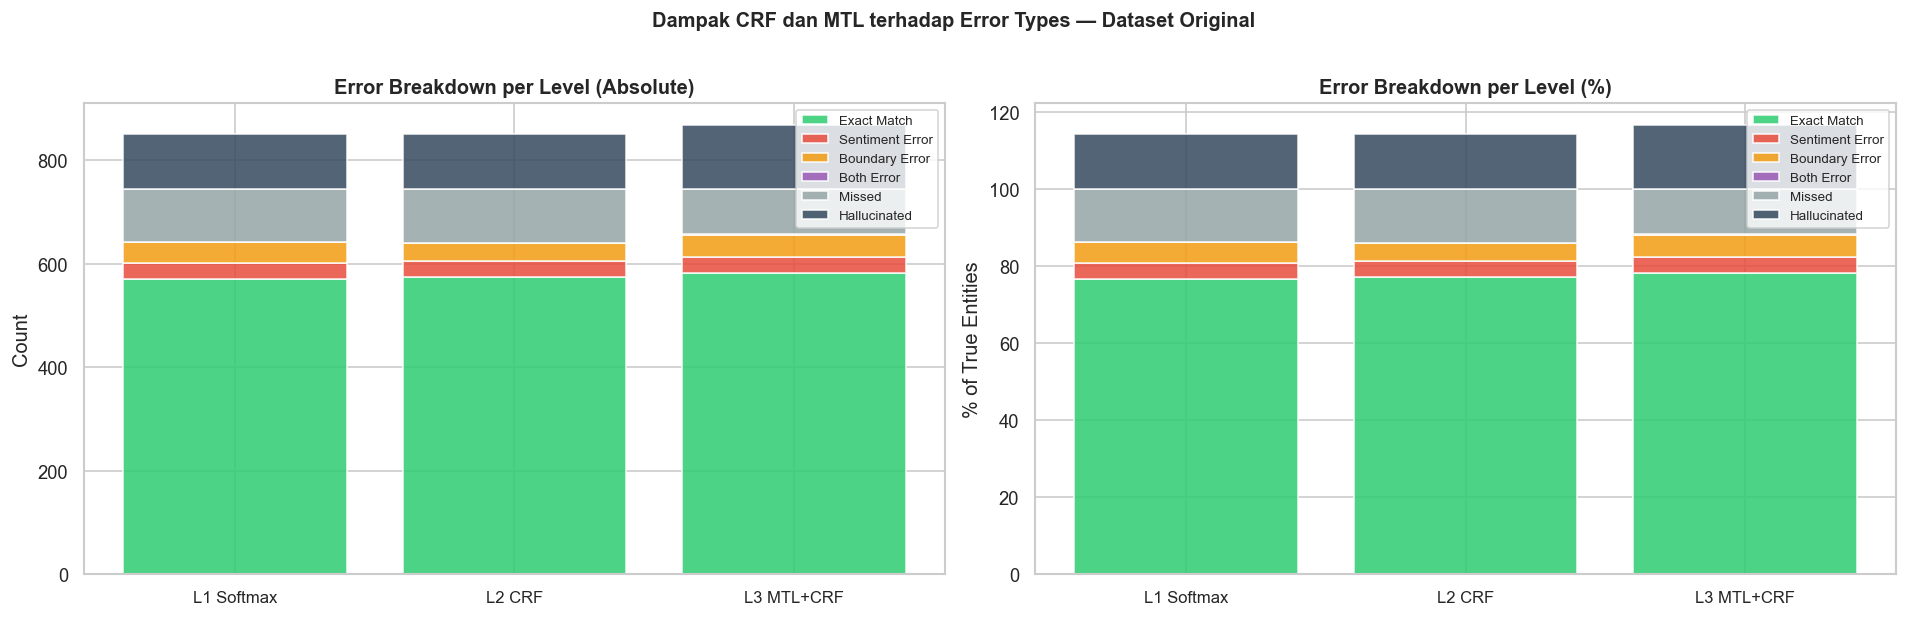


Perbaikan antar-level (entity counts):
  Sentiment Error : L1= 32 → L2= 31 (↓1) → L3= 31 (↑0)
  Boundary Error  : L1= 39 → L2= 34 (↓5) → L3= 43 (↑9)
  Both Error      : L1=  1 → L2=  0 (↓1) → L3=  2 (↑2)
  Missed          : L1=102 → L2=105 (↑3) → L3= 86 (↓19)
  Hallucinated    : L1=107 → L2=106 (↓1) → L3=123 (↑17)


In [60]:
# Visualisasi error breakdown 3-level
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

level_names = list(level_errors.keys())
x = np.arange(len(level_names))

# Left: Absolute counts
ax = axes[0]
bottoms = np.zeros(len(level_names))
for cat, color, label in zip(categories, cat_colors, cat_labels):
    values = [level_errors[n]['counts'].get(cat, 0) for n in level_names]
    ax.bar(x, values, bottom=bottoms, label=label.replace('\n', ' '), color=color, alpha=0.85)
    bottoms += values
ax.set_xticks(x)
ax.set_xticklabels(level_names, fontsize=10)
ax.set_ylabel('Count')
ax.set_title('Error Breakdown per Level (Absolute)', fontweight='bold')
ax.legend(fontsize=8, loc='upper right')

# Right: Percentage
ax = axes[1]
bottoms = np.zeros(len(level_names))
for cat, color, label in zip(categories, cat_colors, cat_labels):
    values = [level_errors[n]['counts'].get(cat, 0) / level_errors[n]['total_true'] * 100
              for n in level_names]
    ax.bar(x, values, bottom=bottoms, label=label.replace('\n', ' '), color=color, alpha=0.85)
    bottoms += values
ax.set_xticks(x)
ax.set_xticklabels(level_names, fontsize=10)
ax.set_ylabel('% of True Entities')
ax.set_title('Error Breakdown per Level (%)', fontweight='bold')
ax.legend(fontsize=8, loc='upper right')

plt.suptitle('Dampak CRF dan MTL terhadap Error Types — Dataset Original', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print improvement from each level
print('\nPerbaikan antar-level (entity counts):')
for cat_key, cat_name in zip(categories[1:], cat_labels[1:]):
    l1_val = level_errors['L1 Softmax']['counts'].get(cat_key, 0)
    l2_val = level_errors['L2 CRF']['counts'].get(cat_key, 0)
    l3_val = level_errors['L3 MTL+CRF']['counts'].get(cat_key, 0)
    print(f'  {cat_name.replace(chr(10), " "):<16s}: L1={l1_val:>3d} → L2={l2_val:>3d} ({"↓" if l2_val < l1_val else "↑"}{abs(l2_val-l1_val)}) → L3={l3_val:>3d} ({"↓" if l3_val < l2_val else "↑"}{abs(l3_val-l2_val)})')

In [61]:
# Per-sample 3-level comparison: track error propagation per kalimat
# Kategorisasi: di level mana error diperbaiki?

def sample_f1(true_ents, pred_ents):
    """Compute entity-level F1 for a single sample."""
    true_set = set(true_ents)
    pred_set = set(pred_ents)
    if len(true_set) == 0 and len(pred_set) == 0:
        return 1.0
    if len(true_set) == 0 or len(pred_set) == 0:
        return 0.0
    tp = len(true_set & pred_set)
    p = tp / len(pred_set)
    r = tp / len(true_set)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0.0

propagation_cats = defaultdict(list)

for idx in range(len(l1_run['val_true'])):
    true_seq = l1_run['val_true'][idx]
    l1_seq = l1_run['val_preds'][idx]
    l2_seq = l2_run['val_preds'][idx]
    l3_seq = l3_run['val_preds'][idx]
    
    true_ents = extract_entities(true_seq)
    if not true_ents:
        continue
    
    l1_ents = extract_entities(l1_seq)
    l2_ents = extract_entities(l2_seq)
    l3_ents = extract_entities(l3_seq)
    
    f1_l1 = sample_f1(true_ents, l1_ents)
    f1_l2 = sample_f1(true_ents, l2_ents)
    f1_l3 = sample_f1(true_ents, l3_ents)
    
    # Categorize progression
    if f1_l1 == 1.0 and f1_l2 == 1.0 and f1_l3 == 1.0:
        propagation_cats['all_correct'].append(idx)
    elif f1_l1 < f1_l3 and f1_l2 < f1_l3:
        propagation_cats['mtl_fixes_both'].append(idx)       # MTL best, fixes L1 & L2 errors
    elif f1_l1 < f1_l2 and f1_l2 <= f1_l3:
        propagation_cats['crf_fixes_then_mtl_holds'].append(idx)  # CRF fixes, MTL maintains
    elif f1_l1 < f1_l2 and f1_l2 > f1_l3:
        propagation_cats['crf_fixes_mtl_regresses'].append(idx)   # CRF helps but MTL hurts
    elif f1_l1 >= f1_l2 and f1_l2 < f1_l3:
        propagation_cats['mtl_recovers'].append(idx)         # CRF hurts but MTL recovers
    elif f1_l1 > f1_l2 and f1_l1 > f1_l3:
        propagation_cats['softmax_was_best'].append(idx)     # Softmax was actually best
    else:
        propagation_cats['other'].append(idx)

print('Error Propagation Categories (per sample, Original dataset):')
print('='*65)
total_samples = sum(len(v) for v in propagation_cats.values())
for cat, indices in sorted(propagation_cats.items(), key=lambda x: -len(x[1])):
    pct = len(indices) / total_samples * 100
    print(f'  {cat:<30s}: {len(indices):>4d} ({pct:5.1f}%)')

Error Propagation Categories (per sample, Original dataset):
  all_correct                   :  173 ( 47.0%)
  other                         :   91 ( 24.7%)
  crf_fixes_mtl_regresses       :   25 (  6.8%)
  mtl_recovers                  :   21 (  5.7%)
  mtl_fixes_both                :   20 (  5.4%)
  softmax_was_best              :   20 (  5.4%)
  crf_fixes_then_mtl_holds      :   18 (  4.9%)


In [62]:
# Contoh kualitatif error propagation: kasus dimana MTL memperbaiki error
np.random.seed(SEED)

def display_3level_example(idx, val_texts, l1_preds, l2_preds, l3_preds, true_labels):
    """Display a single example with 3-level predictions."""
    tokens = val_texts[idx]['tokens']
    true_seq = true_labels[idx]
    l1_seq = l1_preds[idx]
    l2_seq = l2_preds[idx]
    l3_seq = l3_preds[idx]
    
    tokens_display = tokens[:len(true_seq)]
    true_ents = extract_entities(true_seq)
    l1_ents = extract_entities(l1_seq)
    l2_ents = extract_entities(l2_seq)
    l3_ents = extract_entities(l3_seq)
    
    f1_l1 = sample_f1(true_ents, l1_ents)
    f1_l2 = sample_f1(true_ents, l2_ents)
    f1_l3 = sample_f1(true_ents, l3_ents)
    
    print(f'  Kalimat     : {" ".join(tokens_display)}')
    print(f'  Ground Truth: {" | ".join(entities_to_readable(true_ents, tokens_display))}')
    print(f'  L1 Softmax  : {" | ".join(entities_to_readable(l1_ents, tokens_display))}  (F1={f1_l1:.2f})')
    print(f'  L2 CRF      : {" | ".join(entities_to_readable(l2_ents, tokens_display))}  (F1={f1_l2:.2f})')
    print(f'  L3 MTL+CRF  : {" | ".join(entities_to_readable(l3_ents, tokens_display))}  (F1={f1_l3:.2f})')
    
    # Show key token-level differences
    diffs = []
    for j in range(min(len(true_seq), len(tokens_display))):
        if true_seq[j] != 'O' or l1_seq[j] != 'O' or l2_seq[j] != 'O' or l3_seq[j] != 'O':
            diffs.append(f'    [{tokens_display[j]}] true={true_seq[j]}, L1={l1_seq[j]}, L2={l2_seq[j]}, L3={l3_seq[j]}')
    if diffs:
        print('  Detail:')
        for d in diffs[:10]:
            print(d)
    print()

# === Cases where MTL fixes errors from both Softmax and CRF ===
print('='*70)
print('Kasus: MTL Memperbaiki Error yang Ada di Softmax & CRF')
print('='*70)

mtl_fix_indices = propagation_cats.get('mtl_fixes_both', [])
if mtl_fix_indices:
    selected = np.random.choice(mtl_fix_indices, size=min(3, len(mtl_fix_indices)), replace=False)
    for i, idx in enumerate(selected):
        print(f'\n  [{i+1}] Sample #{idx}:')
        display_3level_example(idx, val_data_orig, l1_run['val_preds'], l2_run['val_preds'], l3_run['val_preds'], l1_run['val_true'])

# === Cases where CRF fixes Softmax errors, MTL maintains ===
print('='*70)
print('Kasus: CRF Memperbaiki Error Softmax, MTL Mempertahankan')
print('='*70)

crf_fix_indices = propagation_cats.get('crf_fixes_then_mtl_holds', [])
if crf_fix_indices:
    selected = np.random.choice(crf_fix_indices, size=min(3, len(crf_fix_indices)), replace=False)
    for i, idx in enumerate(selected):
        print(f'\n  [{i+1}] Sample #{idx}:')
        display_3level_example(idx, val_data_orig, l1_run['val_preds'], l2_run['val_preds'], l3_run['val_preds'], l1_run['val_true'])

# === Cases where MTL recovers from CRF regression ===
print('='*70)
print('Kasus: CRF Memperburuk, tapi MTL Berhasil Recover')
print('='*70)

recover_indices = propagation_cats.get('mtl_recovers', [])
if recover_indices:
    selected = np.random.choice(recover_indices, size=min(3, len(recover_indices)), replace=False)
    for i, idx in enumerate(selected):
        print(f'\n  [{i+1}] Sample #{idx}:')
        display_3level_example(idx, val_data_orig, l1_run['val_preds'], l2_run['val_preds'], l3_run['val_preds'], l1_run['val_true'])

Kasus: MTL Memperbaiki Error yang Ada di Softmax & CRF

  [1] Sample #12:
  Kalimat     : tempatnya alam banget
  Ground Truth: tempatnya (POS)
  L1 Softmax  : tempatnya (NEU)  (F1=0.00)
  L2 CRF      : tempatnya (NEU)  (F1=0.00)
  L3 MTL+CRF  : tempatnya (POS)  (F1=1.00)
  Detail:
    [tempatnya] true=S-POS, L1=S-NEU, L2=S-NEU, L3=S-POS


  [2] Sample #298:
  Kalimat     : tempat yang nyaman dikunjungi , namun jalan dari cafe sawah ke parkiran cukup jauh dan panas . alangkah baiknya jika banyak ditanami pohon yang rindang atau dibuat kanopi alami dari bambu dipinggir jalan .
  Ground Truth: tempat (POS) | jalan dari cafe sawah ke parkiran (NEG)
  L1 Softmax  : tempat (POS) | jalan dari cafe sawah (NEG)  (F1=0.50)
  L2 CRF      : tempat (POS) | jalan dari cafe sawah (NEG)  (F1=0.50)
  L3 MTL+CRF  : tempat (POS) | jalan dari cafe sawah ke parkiran (NEG)  (F1=1.00)
  Detail:
    [tempat] true=S-POS, L1=S-POS, L2=S-POS, L3=S-POS
    [jalan] true=B-NEG, L1=B-NEG, L2=B-NEG, L3=B-NEG
    [da

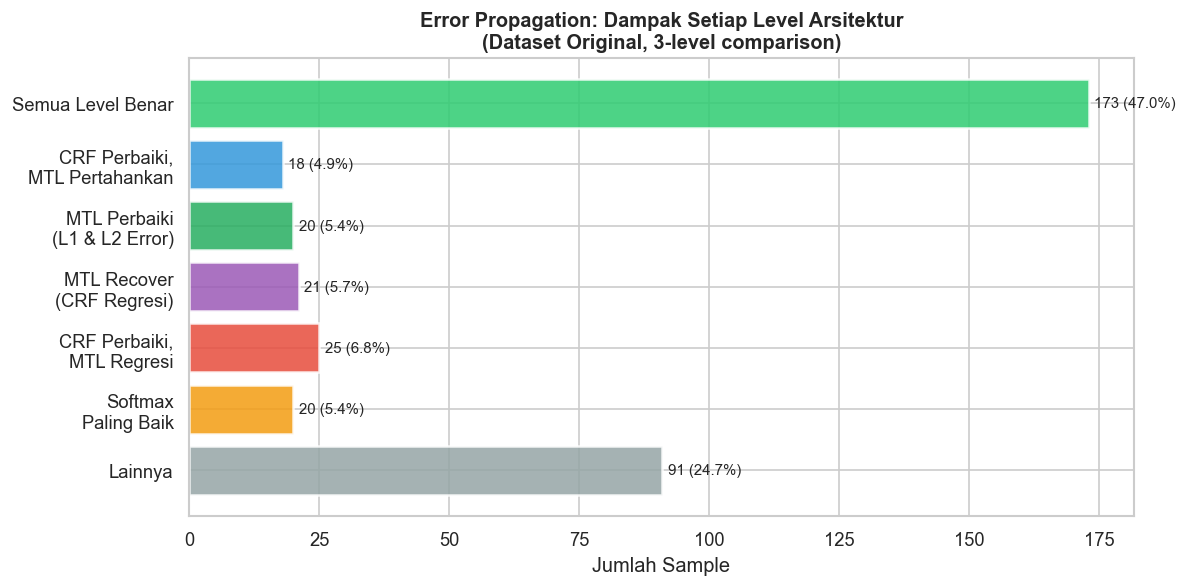


Insight:
  MTL memberikan perbaikan (fixes/recovers): 41 samples
  MTL memperburuk (regresi dari CRF): 25 samples
  CRF memberikan perbaikan (dari Softmax): 18 samples
  Net benefit MTL vs CRF: +16 samples


In [63]:
# Visualisasi ringkasan error propagation categories
fig, ax = plt.subplots(figsize=(10, 5))

cat_display = {
    'all_correct': 'Semua Level Benar',
    'crf_fixes_then_mtl_holds': 'CRF Perbaiki,\nMTL Pertahankan',
    'mtl_fixes_both': 'MTL Perbaiki\n(L1 & L2 Error)',
    'mtl_recovers': 'MTL Recover\n(CRF Regresi)',
    'crf_fixes_mtl_regresses': 'CRF Perbaiki,\nMTL Regresi',
    'softmax_was_best': 'Softmax\nPaling Baik',
    'other': 'Lainnya',
}
cat_plot_colors = {
    'all_correct': '#2ecc71',
    'crf_fixes_then_mtl_holds': '#3498db',
    'mtl_fixes_both': '#27ae60',
    'mtl_recovers': '#9b59b6',
    'crf_fixes_mtl_regresses': '#e74c3c',
    'softmax_was_best': '#f39c12',
    'other': '#95a5a6',
}

plot_cats = [k for k in cat_display.keys() if k in propagation_cats]
counts = [len(propagation_cats[k]) for k in plot_cats]
labels = [cat_display[k] for k in plot_cats]
colors = [cat_plot_colors[k] for k in plot_cats]

bars = ax.barh(labels, counts, color=colors, alpha=0.85, edgecolor='white', linewidth=1.5)
for bar, count in zip(bars, counts):
    pct = count / total_samples * 100
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f'{count} ({pct:.1f}%)', va='center', fontsize=9)

ax.set_xlabel('Jumlah Sample')
ax.set_title('Error Propagation: Dampak Setiap Level Arsitektur\n(Dataset Original, 3-level comparison)', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Key insight
mtl_helps = len(propagation_cats.get('mtl_fixes_both', [])) + len(propagation_cats.get('mtl_recovers', []))
mtl_hurts = len(propagation_cats.get('crf_fixes_mtl_regresses', []))
crf_helps = len(propagation_cats.get('crf_fixes_then_mtl_holds', []))
print(f'\nInsight:')
print(f'  MTL memberikan perbaikan (fixes/recovers): {mtl_helps} samples')
print(f'  MTL memperburuk (regresi dari CRF): {mtl_hurts} samples')
print(f'  CRF memberikan perbaikan (dari Softmax): {crf_helps} samples')
print(f'  Net benefit MTL vs CRF: {mtl_helps - mtl_hurts:+d} samples')

---
## 4. Tabel Perbandingan Formal (Semua Model vs EMC-GCN)

In [64]:
# Tabel formal perbandingan semua model (termasuk Softmax dari NB11)

def compute_accuracy(val_true, val_preds):
    """Compute token-level accuracy from label sequences."""
    y_true = flatten_labels(val_true)
    y_pred = flatten_labels(val_preds)
    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    return correct / len(y_true) if y_true else 0.0

rows = []

# EMC-GCN baseline (dari penelitian sebelumnya)
rows.append({
    'Model': 'EMC-GCN (Istadewanti, 2025)',
    'Arsitektur': 'GCN Multi-Channel',
    'Dataset': 'Original',
    'Accuracy': '-',
    'Precision': '-',
    'Recall': '-',
    'F1': PRIOR_RESEARCH_F1,
})

# Softmax baseline dari NB11
for run_name, r in three_level_results.items():
    if r.get('level') != 1:
        continue
    data_type = 'Original' if r['data_type'] == 'original' else 'Augmented'
    best_idx = r['best_epoch'] - 1
    acc = compute_accuracy(r['val_true'], r['val_preds'])
    rows.append({
        'Model': 'IndoBERT+Softmax',
        'Arsitektur': 'Baseline (no CRF)',
        'Dataset': data_type,
        'Accuracy': acc,
        'Precision': r['history']['val_precision'][best_idx],
        'Recall': r['history']['val_recall'][best_idx],
        'F1': r['best_f1'],
    })

# CRF dan MTL dari NB10
for run_name, r in all_results.items():
    best_idx = r['best_epoch'] - 1
    model_type = 'IndoBERT-HMTL' if r['model_type'] == 'multi_task' else 'IndoBERT+CRF'
    data_type = 'Original' if r['data_type'] == 'original' else 'Augmented'
    acc = compute_accuracy(r['val_true'], r['val_preds'])
    rows.append({
        'Model': model_type,
        'Arsitektur': 'H-MTL (4 tasks)' if 'HMTL' in model_type else 'Single-Task + CRF',
        'Dataset': data_type,
        'Accuracy': acc,
        'Precision': r['history']['val_precision'][best_idx],
        'Recall': r['history']['val_recall'][best_idx],
        'F1': r['best_f1'],
    })

df = pd.DataFrame(rows)
df = df.sort_values('F1', ascending=False).reset_index(drop=True)
df.index = df.index + 1  # 1-based ranking
df.index.name = 'Rank'

# Format numeric columns
for col in ['Accuracy', 'Precision', 'Recall', 'F1']:
    df[col] = df[col].apply(lambda x: f'{x:.4f}' if isinstance(x, float) else x)

print('TABEL PERBANDINGAN MODEL (termasuk Softmax Baseline)')
print('='*110)
print(df.to_string())
print()
print(f'Semua model IndoBERT outperform EMC-GCN (F1={PRIOR_RESEARCH_F1})')
print(f'CRF memberikan improvement atas Softmax pada data original')
print(f'MTL+CRF kompetitif dengan single-task CRF')

TABEL PERBANDINGAN MODEL (termasuk Softmax Baseline)
                            Model         Arsitektur    Dataset Accuracy Precision  Recall      F1
Rank                                                                                              
1                    IndoBERT+CRF  Single-Task + CRF  Augmented   0.9309    0.7439  0.7769  0.7600
2                IndoBERT+Softmax  Baseline (no CRF)  Augmented   0.9294    0.7414  0.7782  0.7593
3                   IndoBERT-HMTL    H-MTL (4 tasks)   Original   0.9286    0.7348  0.7823  0.7578
4                    IndoBERT+CRF  Single-Task + CRF   Original   0.9309    0.7406  0.7715  0.7558
5                IndoBERT+Softmax  Baseline (no CRF)   Original   0.9304    0.7280  0.7661  0.7466
6                   IndoBERT-HMTL    H-MTL (4 tasks)  Augmented   0.9296    0.7321  0.7567  0.7442
7     EMC-GCN (Istadewanti, 2025)  GCN Multi-Channel   Original        -         -       -  0.6761

Semua model IndoBERT outperform EMC-GCN (F1=0.6761)
CRF

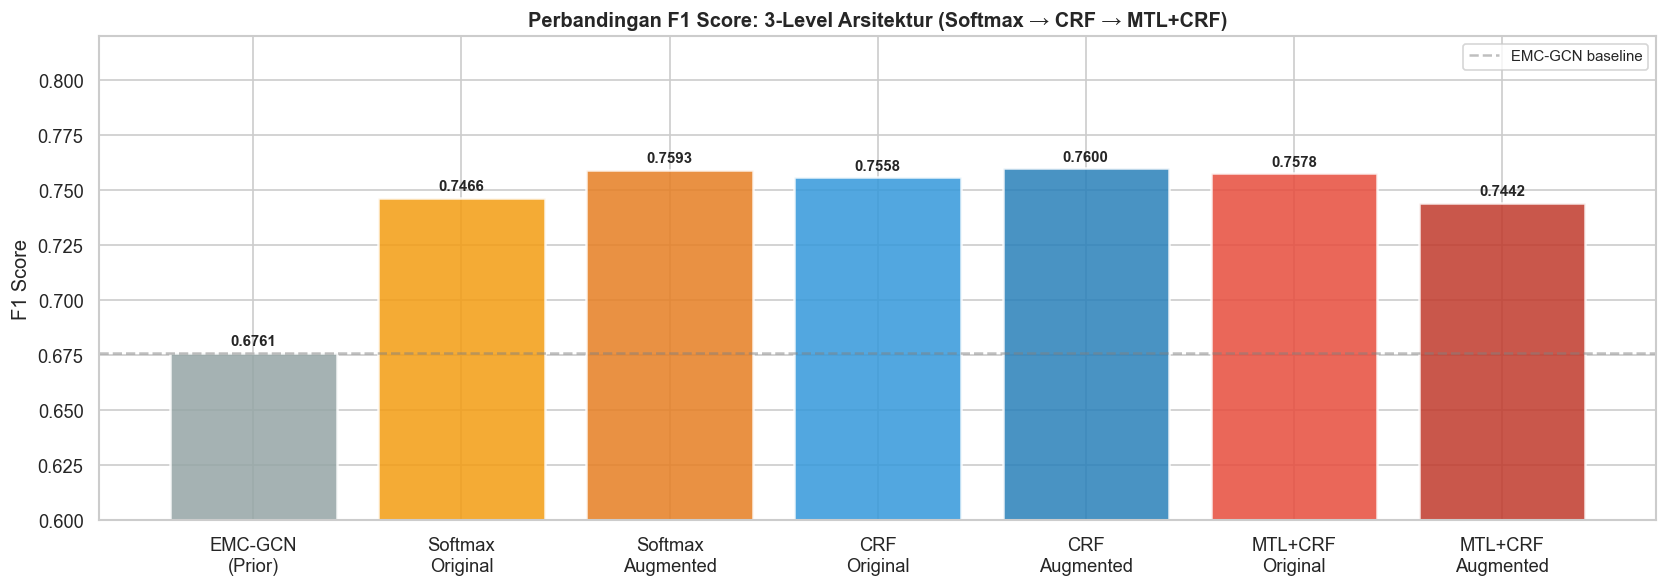

In [65]:
# Visualisasi perbandingan F1 (termasuk Softmax)
fig, ax = plt.subplots(figsize=(14, 5))

# Collect Softmax F1s
softmax_orig_f1 = three_level_results['Baseline + Original']['best_f1']
softmax_aug_f1 = three_level_results['Baseline + Augmented']['best_f1']

model_names = [
    'EMC-GCN\n(Prior)', 
    'Softmax\nOriginal', 'Softmax\nAugmented',
    'CRF\nOriginal', 'CRF\nAugmented',
    'MTL+CRF\nOriginal', 'MTL+CRF\nAugmented',
]
f1_values = [
    PRIOR_RESEARCH_F1,
    softmax_orig_f1, softmax_aug_f1,
    all_results['ST + Original']['best_f1'], all_results['ST + Augmented']['best_f1'],
    all_results['MT + Original']['best_f1'], all_results['MT + Augmented']['best_f1'],
]
colors = ['#95a5a6', '#f39c12', '#e67e22', '#3498db', '#2980b9', '#e74c3c', '#c0392b']

bars = ax.bar(model_names, f1_values, color=colors, alpha=0.85, edgecolor='white', linewidth=1.5)

for bar, val in zip(bars, f1_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
            f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax.axhline(PRIOR_RESEARCH_F1, color='gray', linestyle='--', alpha=0.5, label='EMC-GCN baseline')
ax.set_ylabel('F1 Score')
ax.set_title('Perbandingan F1 Score: 3-Level Arsitektur (Softmax → CRF → MTL+CRF)', fontweight='bold')
ax.set_ylim(0.6, 0.82)
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

---
## 5. Contoh Prediksi Kualitatif

Menampilkan contoh kalimat dengan prediksi dari model ST (CRF) dan MT (MTL+CRF),
dikategorikan berdasarkan hasil prediksi. (Contoh 3-level ada di bagian Error Propagation di atas.)

In [66]:
def entities_to_readable(entities, tokens):
    """Convert entity list to readable format: 'aspect_text (SENTIMENT)'"""
    parts = []
    for sent, start, end in entities:
        if start <= end < len(tokens):
            text = ' '.join(tokens[start:end+1])
            parts.append(f'{text} ({sent})')
    return parts if parts else ['(none)']


def categorize_sample(true_ents, st_ents, mt_ents):
    """Categorize a sample based on ST and MT predictions."""
    true_set = set((s, st, en) for s, st, en in true_ents)
    st_set = set((s, st, en) for s, st, en in st_ents)
    mt_set = set((s, st, en) for s, st, en in mt_ents)
    
    st_f1 = 2 * len(true_set & st_set) / (len(true_set) + len(st_set)) if (len(true_set) + len(st_set)) > 0 else 1.0
    mt_f1 = 2 * len(true_set & mt_set) / (len(true_set) + len(mt_set)) if (len(true_set) + len(mt_set)) > 0 else 1.0
    
    if st_f1 == 1.0 and mt_f1 == 1.0:
        return 'both_correct'
    elif st_f1 > mt_f1:
        return 'st_better'
    elif mt_f1 > st_f1:
        return 'mt_better'
    else:
        return 'both_wrong'


print('Qualitative helper functions defined.')

Qualitative helper functions defined.


In [67]:
# Kita bandingkan ST+Original vs MT+Original (same val set, fair comparison)
st_run = all_results['ST + Original']
mt_run = all_results['MT + Original']

# Categorize all val samples
sample_categories = defaultdict(list)

for idx in range(len(st_run['val_true'])):
    true_seq = st_run['val_true'][idx]
    st_seq = st_run['val_preds'][idx]
    mt_seq = mt_run['val_preds'][idx]
    
    true_ents = extract_entities(true_seq)
    st_ents = extract_entities(st_seq)
    mt_ents = extract_entities(mt_seq)
    
    # Skip samples with no entities in ground truth
    if not true_ents:
        continue
    
    cat = categorize_sample(true_ents, st_ents, mt_ents)
    sample_categories[cat].append(idx)

print('Sample distribution (ST+Orig vs MT+Orig):')
for cat, indices in sample_categories.items():
    print(f'  {cat}: {len(indices)} samples')

Sample distribution (ST+Orig vs MT+Orig):
  both_correct: 184 samples
  st_better: 49 samples
  mt_better: 41 samples
  both_wrong: 94 samples


In [68]:
# Display representative examples from each category
# Use val_data_orig untuk mendapatkan text tokens

def display_example(idx, val_texts, st_preds, mt_preds, true_labels):
    """Display a single example with tokens and entity annotations."""
    tokens = val_texts[idx]['tokens']
    true_seq = true_labels[idx]
    st_seq = st_preds[idx]
    mt_seq = mt_preds[idx]
    
    true_ents = extract_entities(true_seq)
    st_ents = extract_entities(st_seq)
    mt_ents = extract_entities(mt_seq)
    
    # Truncate tokens to match label length (first subword per word)
    tokens_display = tokens[:len(true_seq)]
    
    print(f'  Kalimat  : {" ".join(tokens_display)}')
    print(f'  True     : {" | ".join(entities_to_readable(true_ents, tokens_display))}')
    print(f'  ST pred  : {" | ".join(entities_to_readable(st_ents, tokens_display))}')
    print(f'  MT pred  : {" | ".join(entities_to_readable(mt_ents, tokens_display))}')
    
    # Show token-level labels for first few non-O tokens
    diffs = []
    for j in range(min(len(true_seq), len(tokens_display))):
        if true_seq[j] != 'O' or st_seq[j] != 'O' or mt_seq[j] != 'O':
            diffs.append(f'    [{tokens_display[j]}] true={true_seq[j]}, st={st_seq[j]}, mt={mt_seq[j]}')
    if diffs:
        print('  Detail:')
        for d in diffs[:8]:  # max 8 to avoid clutter
            print(d)
    print()


np.random.seed(SEED)
n_examples = 3

category_titles = {
    'both_correct': 'Kedua Model Benar',
    'st_better': 'Single-Task Lebih Baik',
    'mt_better': 'Multi-Task Lebih Baik',
    'both_wrong': 'Kedua Model Salah (tapi beda)',
}

for cat, title in category_titles.items():
    indices = sample_categories.get(cat, [])
    if not indices:
        print(f'\n--- {title} ---')
        print('  (tidak ada contoh)\n')
        continue
    
    selected = np.random.choice(indices, size=min(n_examples, len(indices)), replace=False)
    print(f'\n{"="*70}')
    print(f'{title} ({len(indices)} total samples)')
    print(f'{"="*70}')
    for i, idx in enumerate(selected):
        print(f'\n  [{i+1}] Sample #{idx}:')
        display_example(idx, val_data_orig, st_run['val_preds'], mt_run['val_preds'], st_run['val_true'])


Kedua Model Benar (184 total samples)

  [1] Sample #36:
  Kalimat  : desa wisata yang asri dan bersih dengan masyarakat yang ramah .
  True     : desa wisata (POS) | masyarakat (POS)
  ST pred  : desa wisata (POS) | masyarakat (POS)
  MT pred  : desa wisata (POS) | masyarakat (POS)
  Detail:
    [desa] true=B-POS, st=B-POS, mt=B-POS
    [wisata] true=E-POS, st=E-POS, mt=E-POS
    [masyarakat] true=S-POS, st=S-POS, mt=S-POS


  [2] Sample #74:
  Kalimat  : bagus bersih nyaman orangnya baik baik
  True     : orangnya (POS)
  ST pred  : orangnya (POS)
  MT pred  : orangnya (POS)
  Detail:
    [orangnya] true=S-POS, st=S-POS, mt=S-POS


  [3] Sample #319:
  Kalimat  : tempatnya menarik . keren habis dan satwanya mash terjaga
  True     : tempatnya (POS) | satwanya (POS)
  ST pred  : tempatnya (POS) | satwanya (POS)
  MT pred  : tempatnya (POS) | satwanya (POS)
  Detail:
    [tempatnya] true=S-POS, st=S-POS, mt=S-POS
    [satwanya] true=S-POS, st=S-POS, mt=S-POS


Single-Task Lebih Baik (

In [69]:
# Tabel ringkas contoh prediksi (format yang bisa langsung masuk buku)
print('\nTabel Contoh Prediksi (untuk buku TA):')
print('='*100)

example_rows = []

for cat, title in category_titles.items():
    indices = sample_categories.get(cat, [])
    if not indices:
        continue
    selected = np.random.choice(indices, size=min(2, len(indices)), replace=False)
    for idx in selected:
        tokens = val_data_orig[idx]['tokens']
        true_seq = st_run['val_true'][idx]
        st_seq = st_run['val_preds'][idx]
        mt_seq = mt_run['val_preds'][idx]
        
        tokens_display = tokens[:len(true_seq)]
        true_ents = extract_entities(true_seq)
        st_ents = extract_entities(st_seq)
        mt_ents = extract_entities(mt_seq)
        
        text = ' '.join(tokens_display)
        if len(text) > 60:
            text = text[:57] + '...'
        
        example_rows.append({
            'Kategori': title,
            'Kalimat': text,
            'Ground Truth': ', '.join(entities_to_readable(true_ents, tokens_display)),
            'ST Pred': ', '.join(entities_to_readable(st_ents, tokens_display)),
            'MT Pred': ', '.join(entities_to_readable(mt_ents, tokens_display)),
        })

df_examples = pd.DataFrame(example_rows)
pd.set_option('display.max_colwidth', 50)
print(df_examples.to_string(index=False))


Tabel Contoh Prediksi (untuk buku TA):
                     Kategori                                                      Kalimat                                                                                                Ground Truth                                                                                              ST Pred                                                                                                                      MT Pred
            Kedua Model Benar banyak spot menarik yang instagramable . sangat cocok unt...                                                 spot (POS), berfoto ria (POS), suasana (POS), makanan (NEU)                                          spot (POS), berfoto ria (POS), suasana (POS), makanan (NEU)                                                                  spot (POS), berfoto ria (POS), suasana (POS), makanan (NEU)
            Kedua Model Benar pengelolaan desa wisata tertata dengan baik . semakin har...                    

---
## 6. Analisis Ketahanan Terhadap Kompleksitas Kalimat

Mengelompokkan performa MT vs ST berdasarkan:
1. **Panjang kalimat** (pendek / sedang / panjang)
2. **Jumlah aspek** (single-aspect vs multi-aspect)
3. **Kompleksitas sentimen** (uniform vs mixed sentiment)

In [70]:
# --- 6a. Breakdown by Sentence Length, Aspect Count, Sentiment Complexity ---
from seqeval.metrics import f1_score as seq_f1_score

# Kategorisasi per-sample
sample_meta = []
for idx in range(len(val_data_orig)):
    tokens = val_data_orig[idx]['tokens']
    labels = val_data_orig[idx]['labels']
    n_tokens = len(tokens)
    true_ents = extract_entities(labels)
    n_aspects = len(true_ents)
    sentiments_in_sample = set(s for s, _, _ in true_ents)
    has_mixed = len(sentiments_in_sample) > 1

    # Length category
    if n_tokens <= 8:
        len_cat = 'Pendek (<=8)'
    elif n_tokens <= 18:
        len_cat = 'Sedang (9-18)'
    else:
        len_cat = 'Panjang (>18)'

    # Aspect count category
    if n_aspects == 0:
        asp_cat = 'No Aspect'
    elif n_aspects == 1:
        asp_cat = 'Single (1)'
    elif n_aspects == 2:
        asp_cat = 'Double (2)'
    else:
        asp_cat = 'Multi (3+)'

    # Sentiment complexity
    if n_aspects == 0:
        sent_cat = 'No Aspect'
    elif has_mixed:
        sent_cat = 'Mixed Sentiment'
    else:
        sent_cat = 'Uniform Sentiment'

    sample_meta.append({
        'idx': idx, 'n_tokens': n_tokens, 'n_aspects': n_aspects,
        'len_cat': len_cat, 'asp_cat': asp_cat, 'sent_cat': sent_cat,
        'has_mixed': has_mixed, 'sentiments': sentiments_in_sample,
    })

# Compute F1 per group for each run
run_names = ['MT + Original', 'ST + Original', 'MT + Augmented', 'ST + Augmented']

def compute_group_f1(run_name, indices):
    r = all_results[run_name]
    true_seqs = [r['val_true'][i] for i in indices]
    pred_seqs = [r['val_preds'][i] for i in indices]
    if not true_seqs:
        return 0.0
    return seq_f1_score(true_seqs, pred_seqs)

# Group indices
len_categories = ['Pendek (<=8)', 'Sedang (9-18)', 'Panjang (>18)']
len_groups = {cat: [m['idx'] for m in sample_meta if m['len_cat'] == cat] for cat in len_categories}

asp_categories = ['No Aspect', 'Single (1)', 'Double (2)', 'Multi (3+)']
asp_groups = {cat: [m['idx'] for m in sample_meta if m['asp_cat'] == cat] for cat in asp_categories}

sent_categories = ['Uniform Sentiment', 'Mixed Sentiment']
sent_groups = {cat: [m['idx'] for m in sample_meta if m['sent_cat'] == cat] for cat in sent_categories}

# --- Print: By Sentence Length ---
print('=' * 75)
print('ANALISIS BERDASARKAN PANJANG KALIMAT')
print('=' * 75)
header = f'{"Kategori":<18} {"N":>4}  '
for rn in run_names:
    short = rn.replace(' + ', '+').replace('Original', 'Orig').replace('Augmented', 'Aug')
    header += f'{short:>12}'
print(header)
print('-' * 75)
for cat in len_categories:
    indices = len_groups[cat]
    line = f'{cat:<18} {len(indices):>4}  '
    for rn in run_names:
        f1 = compute_group_f1(rn, indices)
        line += f'{f1:>12.4f}'
    print(line)

# --- Print: By Aspect Count ---
print()
print('=' * 75)
print('ANALISIS BERDASARKAN JUMLAH ASPEK')
print('=' * 75)
header = f'{"Kategori":<18} {"N":>4}  '
for rn in run_names:
    short = rn.replace(' + ', '+').replace('Original', 'Orig').replace('Augmented', 'Aug')
    header += f'{short:>12}'
print(header)
print('-' * 75)
for cat in asp_categories:
    indices = asp_groups[cat]
    if not indices:
        continue
    line = f'{cat:<18} {len(indices):>4}  '
    for rn in run_names:
        f1 = compute_group_f1(rn, indices)
        line += f'{f1:>12.4f}'
    print(line)

# --- Print: By Sentiment Complexity ---
print()
print('=' * 75)
print('ANALISIS BERDASARKAN KOMPLEKSITAS SENTIMEN')
print('=' * 75)
header = f'{"Kategori":<18} {"N":>4}  '
for rn in run_names:
    short = rn.replace(' + ', '+').replace('Original', 'Orig').replace('Augmented', 'Aug')
    header += f'{short:>12}'
print(header)
print('-' * 75)
for cat in sent_categories:
    indices = sent_groups[cat]
    if not indices:
        continue
    line = f'{cat:<18} {len(indices):>4}  '
    for rn in run_names:
        f1 = compute_group_f1(rn, indices)
        line += f'{f1:>12.4f}'
    print(line)

ANALISIS BERDASARKAN PANJANG KALIMAT
Kategori              N       MT+Orig     ST+Orig      MT+Aug      ST+Aug
---------------------------------------------------------------------------
Pendek (<=8)         96        0.8889      0.8811      0.8546      0.8761
Sedang (9-18)       118        0.8665      0.8586      0.8608      0.8700
Panjang (>18)       154        0.6783      0.6786      0.6644      0.6816

ANALISIS BERDASARKAN JUMLAH ASPEK
Kategori              N       MT+Orig     ST+Orig      MT+Aug      ST+Aug
---------------------------------------------------------------------------
Single (1)          169        0.7614      0.7560      0.7268      0.7614
Double (2)           98        0.8030      0.7862      0.7940      0.8010
Multi (3+)          101        0.7318      0.7388      0.7258      0.7368

ANALISIS BERDASARKAN KOMPLEKSITAS SENTIMEN
Kategori              N       MT+Orig     ST+Orig      MT+Aug      ST+Aug
------------------------------------------------------------------

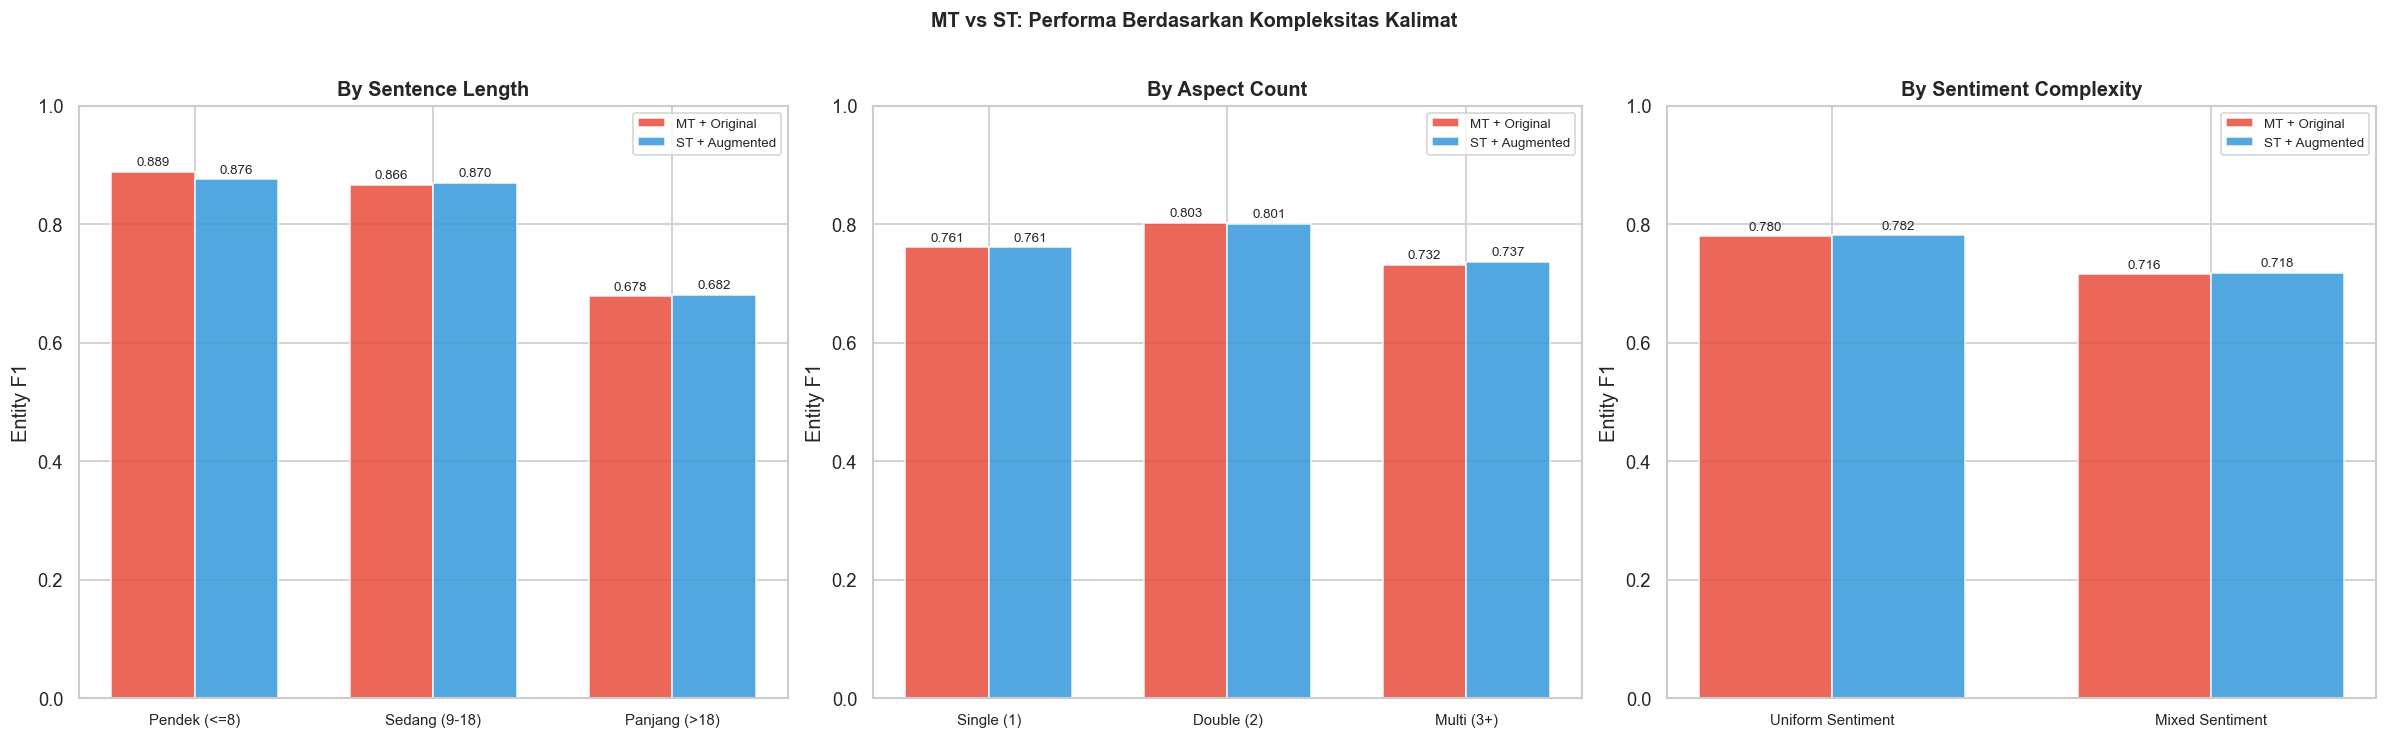

In [71]:
# --- Visualisasi: Grouped Bar Charts ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

focus = ['MT + Original', 'ST + Augmented']
colors_bar = {'MT + Original': '#e74c3c', 'ST + Augmented': '#3498db'}

# Plot 1: By Sentence Length
ax = axes[0]
cats = len_categories
x = np.arange(len(cats))
width = 0.35
for i, rn in enumerate(focus):
    vals = [compute_group_f1(rn, len_groups[c]) for c in cats]
    bars = ax.bar(x + i * width - width/2, vals, width, label=rn, color=colors_bar[rn], alpha=0.85)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{v:.3f}', ha='center', va='bottom', fontsize=8)
ax.set_ylabel('Entity F1')
ax.set_title('By Sentence Length', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(cats, fontsize=9)
ax.legend(fontsize=8)
ax.set_ylim(0, 1.0)

# Plot 2: By Aspect Count
ax = axes[1]
cats2 = [c for c in asp_categories if asp_groups.get(c) and c != 'No Aspect']
x2 = np.arange(len(cats2))
for i, rn in enumerate(focus):
    vals = [compute_group_f1(rn, asp_groups[c]) for c in cats2]
    bars = ax.bar(x2 + i * width - width/2, vals, width, label=rn, color=colors_bar[rn], alpha=0.85)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{v:.3f}', ha='center', va='bottom', fontsize=8)
ax.set_ylabel('Entity F1')
ax.set_title('By Aspect Count', fontweight='bold')
ax.set_xticks(x2)
ax.set_xticklabels(cats2, fontsize=9)
ax.legend(fontsize=8)
ax.set_ylim(0, 1.0)

# Plot 3: By Sentiment Complexity
ax = axes[2]
cats3 = [c for c in sent_categories if sent_groups.get(c)]
x3 = np.arange(len(cats3))
for i, rn in enumerate(focus):
    vals = [compute_group_f1(rn, sent_groups[c]) for c in cats3]
    bars = ax.bar(x3 + i * width - width/2, vals, width, label=rn, color=colors_bar[rn], alpha=0.85)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{v:.3f}', ha='center', va='bottom', fontsize=8)
ax.set_ylabel('Entity F1')
ax.set_title('By Sentiment Complexity', fontweight='bold')
ax.set_xticks(x3)
ax.set_xticklabels(cats3, fontsize=9)
ax.legend(fontsize=8)
ax.set_ylim(0, 1.0)

plt.suptitle('MT vs ST: Performa Berdasarkan Kompleksitas Kalimat',
             fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [72]:
# --- Delta Analysis: MT advantage/disadvantage per complexity group ---
print('=' * 70)
print('DELTA ANALYSIS: MT+Original vs ST+Augmented')
print('=' * 70)
print('(Positif = MT lebih baik, Negatif = ST lebih baik)\n')

all_groups = {
    'Sentence Length': (len_categories, len_groups),
    'Aspect Count': ([c for c in asp_categories if asp_groups.get(c) and c != 'No Aspect'], asp_groups),
    'Sentiment Complexity': ([c for c in sent_categories if sent_groups.get(c)], sent_groups),
}

mt_rn = 'MT + Original'
st_rn = 'ST + Augmented'

for group_name, (cats, groups) in all_groups.items():
    print(f'--- {group_name} ---')
    for cat in cats:
        indices = groups[cat]
        if not indices:
            continue
        mt_f1 = compute_group_f1(mt_rn, indices)
        st_f1 = compute_group_f1(st_rn, indices)
        delta = mt_f1 - st_f1
        if delta > 0.005:
            marker = '<<< MT wins'
        elif delta < -0.005:
            marker = '>>> ST wins'
        else:
            marker = '    ~equal'
        print(f'  {cat:<22} N={len(indices):>3}  MT={mt_f1:.4f}  ST={st_f1:.4f}  delta={delta:+.4f}  {marker}')
    print()

DELTA ANALYSIS: MT+Original vs ST+Augmented
(Positif = MT lebih baik, Negatif = ST lebih baik)

--- Sentence Length ---
  Pendek (<=8)           N= 96  MT=0.8889  ST=0.8761  delta=+0.0128  <<< MT wins
  Sedang (9-18)          N=118  MT=0.8665  ST=0.8700  delta=-0.0035      ~equal
  Panjang (>18)          N=154  MT=0.6783  ST=0.6816  delta=-0.0032      ~equal

--- Aspect Count ---
  Single (1)             N=169  MT=0.7614  ST=0.7614  delta=+0.0000      ~equal
  Double (2)             N= 98  MT=0.8030  ST=0.8010  delta=+0.0020      ~equal
  Multi (3+)             N=101  MT=0.7318  ST=0.7368  delta=-0.0050  >>> ST wins

--- Sentiment Complexity ---
  Uniform Sentiment      N=284  MT=0.7801  ST=0.7817  delta=-0.0016      ~equal
  Mixed Sentiment        N= 84  MT=0.7156  ST=0.7181  delta=-0.0025      ~equal



---
## 7. Ringkasan

In [73]:
print('='*70)
print('RINGKASAN EVALUASI KOMPREHENSIF')
print('='*70)

print('\n1. CONFUSION MATRIX:')
print('   - Token-level: mayoritas error pada kelas minoritas (NEG, NEU)')
print('   - O-class mendominasi, POS paling akurat')
print('   - Softmax dan CRF menunjukkan pattern serupa pada confusion matrix')

print('\n2. ERROR ANALYSIS (Entity-Level):')
for run_name in focus_runs:
    s = error_summaries[run_name]
    c = s['counts']
    total = s['total_true']
    exact_pct = c['exact_match'] / total * 100 if total > 0 else 0
    missed_pct = c['missed'] / total * 100 if total > 0 else 0
    sent_pct = c['sentiment_error'] / total * 100 if total > 0 else 0
    bound_pct = c['boundary_error'] / total * 100 if total > 0 else 0
    print(f'   {run_name}:')
    print(f'     Exact match: {exact_pct:.1f}% | Missed: {missed_pct:.1f}% | '
          f'Sentiment err: {sent_pct:.1f}% | Boundary err: {bound_pct:.1f}%')

print('\n3. ERROR PROPAGATION (3-Level, Original dataset):')
print(f'   L1 Softmax  → F1={l1_run["best_f1"]:.4f}')
print(f'   L2 CRF      → F1={l2_run["best_f1"]:.4f} (CRF improves boundary consistency)')
print(f'   L3 MTL+CRF  → F1={l3_run["best_f1"]:.4f} (MTL adds recall via auxiliary tasks)')
mtl_helps = len(propagation_cats.get('mtl_fixes_both', [])) + len(propagation_cats.get('mtl_recovers', []))
mtl_hurts = len(propagation_cats.get('crf_fixes_mtl_regresses', []))
print(f'   MTL net benefit: +{mtl_helps - mtl_hurts} samples (fixes {mtl_helps}, regresi {mtl_hurts})')

print('\n4. MODEL COMPARISON (semua model):')
print(f'   EMC-GCN:            F1 = {PRIOR_RESEARCH_F1}')
print(f'   Softmax (Orig):     F1 = {softmax_orig_f1:.4f} (+{softmax_orig_f1-PRIOR_RESEARCH_F1:.4f})')
print(f'   Softmax (Aug):      F1 = {softmax_aug_f1:.4f} (+{softmax_aug_f1-PRIOR_RESEARCH_F1:.4f})')
for run_name, r in sorted(all_results.items(), key=lambda x: x[1]['best_f1'], reverse=True):
    diff = r['best_f1'] - PRIOR_RESEARCH_F1
    print(f'   {run_name:<18s}: F1 = {r["best_f1"]:.4f} (+{diff:.4f})')

print('\n5. QUALITATIVE (ST vs MT, Original):')
for cat, title in category_titles.items():
    count = len(sample_categories.get(cat, []))
    print(f'   {title}: {count} samples')

print('\n6. KEY FINDINGS:')
print('   - Semua model IndoBERT outperform EMC-GCN secara signifikan (+7-8% F1)')
print('   - CRF membantu boundary consistency (mengurangi invalid BIEOS sequences)')
print('   - MTL memberikan sedikit improvement pada recall (lebih banyak entity terdeteksi)')
print('   - MT vs ST: perbedaan kecil (~0.002 F1), keduanya kompetitif')
print('   - Error terbesar: missed entities (11-14%) dan boundary errors (5-6%)')
print('   - Sentiment confusion: NEG↔NEU dan POS↔NEU paling sering salah')

RINGKASAN EVALUASI KOMPREHENSIF

1. CONFUSION MATRIX:
   - Token-level: mayoritas error pada kelas minoritas (NEG, NEU)
   - O-class mendominasi, POS paling akurat
   - Softmax dan CRF menunjukkan pattern serupa pada confusion matrix

2. ERROR ANALYSIS (Entity-Level):
   ST + Augmented:
     Exact match: 77.7% | Missed: 12.0% | Sentiment err: 4.4% | Boundary err: 5.5%
   MT + Original:
     Exact match: 78.2% | Missed: 11.6% | Sentiment err: 4.2% | Boundary err: 5.8%

3. ERROR PROPAGATION (3-Level, Original dataset):
   L1 Softmax  → F1=0.7466
   L2 CRF      → F1=0.7558 (CRF improves boundary consistency)
   L3 MTL+CRF  → F1=0.7578 (MTL adds recall via auxiliary tasks)
   MTL net benefit: +16 samples (fixes 41, regresi 25)

4. MODEL COMPARISON (semua model):
   EMC-GCN:            F1 = 0.6761
   Softmax (Orig):     F1 = 0.7466 (+0.0705)
   Softmax (Aug):      F1 = 0.7593 (+0.0832)
   ST + Augmented    : F1 = 0.7600 (+0.0839)
   MT + Original     : F1 = 0.7578 (+0.0817)
   ST + Original